In [1]:
#DAA

from base_functions import *

start, end =  "2020-01-10", "2022-10-10"
riskTickers = {
    "snp":"^GSPC", #미국 대형주
    "nasdaq":"QQQ",
    "iwm":"IWM", #미국 소형주
    "vgk":"VGK", #유럽 주식
    "ewj":"EWJ", #일본 주식
    "eem":"EEM", #개발도상국 주식
    "vnq":"VNQ", #부동산
    "GLD":"GLD", #금 
    "dbc":"DBC", #원자재
    "hyg":"HYG", #하이랜드 채권
    "lqd":"LQD", #미국 회사채 
    "tlt":"TLT", #미국 장기체   
}

safeTickers = {
    "lqd": "LQD", #미국 회사채
    "ief": "IEF", #미국 중기국채
    "shy": "SHY", #미국 단기국채 
}

canaryTickers = {
    "vwo": "VWO", #개발도상국 etf
    "bnd": "BND", #미국 혼합채권
}

riskCloseData = getCloseDataAll(riskTickers, start, end)
safeCloseData = getCloseDataAll(safeTickers, start, end)
canaryCloseData = getCloseDataAll(canaryTickers, start, end)
print(f"risk:\n{riskCloseData}\nsafe:\n{safeCloseData}")

risk:
                    snp      nasdaq         iwm        vgk        ewj  \
Date                                                                    
2020-01-09  3274.699951  218.990005  165.509995  58.490002  59.939999   
2020-01-10  3265.350098  218.429993  164.889999  58.209999  59.520000   
2020-01-13  3288.129883  220.949997  165.960007  58.500000  59.860001   
2020-01-14  3283.149902  220.080002  166.570007  58.540001  59.880001   
2020-01-15  3289.290039  220.169998  167.369995  58.560001  59.660000   
...                 ...         ...         ...        ...        ...   
2022-10-04  3790.929932  282.130005  176.000000  49.389999  51.320000   
2022-10-05  3783.280029  281.980011  174.699997  48.619999  50.779999   
2022-10-06  3744.520020  279.760010  173.720001  47.560001  50.320000   
2022-10-07  3639.659912  269.100006  168.610001  46.669998  49.810001   
2022-10-10  3612.389893  266.410004  167.669998  46.470001  49.610001   

                  eem        vnq         GLD

In [2]:
pd.set_option("display.max_rows", 10)
def getMomentumScore(rebalDate):
    momentumScore = rebalDate.copy()
    for month, weight in [[12, 1], [4, 3], [2, 6], [1, 12]]:
        momentumScore += (rebalDate - rebalDate.shift(month).fillna(method="bfill")) * weight
    
    return momentumScore


In [18]:
def getCanaryPercentage(canaryCloseData):
    priceOnRebalDate = canaryCloseData.loc[getRebalancingDate(canaryCloseData)] 
    momentumScore = getMomentumScore(priceOnRebalDate)

    status = pd.DataFrame([], index=momentumScore.index)
    for asset, assetMomentumScore in momentumScore.iteritems():
        status[asset] = np.where(assetMomentumScore < 0, 0, 1)
    status.iloc[0] = 0
    status["risk"] = 0.5 * status.apply(np.sum, axis=1)
    status["safe"] = 1 - status["risk"]
    status = status.drop(columns=["vwo", "bnd"] , axis=0)

    return status

        
percentage = getCanaryPercentage(canaryCloseData)
percentage

,risk,safe
Date,,
2020-01-31,0.0,1.0
2020-02-28,1.0,0.0
2020-03-31,0.5,0.5
2020-04-30,1.0,0.0
2020-05-29,1.0,0.0
...,...,...
2022-06-30,0.5,0.5
2022-07-29,0.5,0.5
2022-08-31,1.0,0.0


In [26]:
def getSafeWeights(closeDataSet, percentage):
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    momentumScore = getMomentumScore(priceOnRebalDate)

    weights = pd.DataFrame([], index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
    max_values = momentumScore.idxmax(axis=1)

    for idx, asset in max_values.iteritems():
        weights.loc[idx][asset] = 1 * percentage.loc[idx]["safe"]
    weights.fillna(0, inplace=True)

    return weights

safeWeights = getSafeWeights(safeCloseData, percentage)
safeWeights

    

,lqd,ief,shy
Date,,,
2020-01-31,1.0,0.0,0.0
2020-02-28,0.0,0.0,0.0
2020-03-31,0.0,0.5,0.0
2020-04-30,0.0,0.0,0.0
2020-05-29,0.0,0.0,0.0
...,...,...,...
2022-06-30,0.0,0.0,0.5
2022-07-29,0.0,0.5,0.0
2022-08-31,0.0,0.0,0.0


In [30]:
def getRiskWeights(closeDataSet, percentage):
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    momentumScore = getMomentumScore(priceOnRebalDate)
        
    weights = pd.DataFrame([], index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
    for row in momentumScore.iloc:
        target = row.sort_values(ascending=False)[0:6]
        for name, item in target.iteritems():
            weights.loc[row.name][name] = (1 / 6) * percentage.loc[row.name]["risk"]

    weights.fillna(0, inplace=True)
    print(weights)

    return weights

riskWeights = getRiskWeights(riskCloseData, percentage)

                 snp    nasdaq       iwm  vgk       ewj       eem       vnq  \
Date                                                                          
2020-01-31  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
2020-02-28  0.000000  0.000000  0.000000  0.0  0.000000  0.166667  0.000000   
2020-03-31  0.000000  0.000000  0.000000  0.0  0.083333  0.083333  0.000000   
2020-04-30  0.166667  0.166667  0.166667  0.0  0.000000  0.000000  0.000000   
2020-05-29  0.166667  0.166667  0.166667  0.0  0.000000  0.000000  0.000000   
...              ...       ...       ...  ...       ...       ...       ...   
2022-06-30  0.000000  0.000000  0.000000  0.0  0.000000  0.083333  0.000000   
2022-07-29  0.083333  0.083333  0.083333  0.0  0.000000  0.000000  0.083333   
2022-08-31  0.166667  0.166667  0.166667  0.0  0.000000  0.166667  0.000000   
2022-09-30  0.000000  0.000000  0.000000  0.0  0.000000  0.000000  0.000000   
2022-10-10  0.083333  0.000000  0.083333  0.0  0.083

In [32]:
pd.set_option("display.max_rows", 10)
def getWeights(riskWeights, safeWeights):
    return pd.concat([riskWeights, safeWeights], axis=1)

weights = getWeights(riskWeights, safeWeights)
weights


weights

,snp,nasdaq,iwm,vgk,ewj,eem,vnq,GLD,dbc,hyg,lqd,tlt,lqd,ief,shy
Date,,,,,,,,,,,,,,,
2020-01-31,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2020-02-28,0.000000,0.000000,0.000000,0.0,0.000000,0.166667,0.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.0,0.0,0.0
2020-03-31,0.000000,0.000000,0.000000,0.0,0.083333,0.083333,0.000000,0.083333,0.083333,0.000000,0.083333,0.083333,0.0,0.5,0.0
2020-04-30,0.166667,0.166667,0.166667,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.0,0.0,0.0
2020-05-29,0.166667,0.166667,0.166667,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.083333,0.083333,0.083333,0.083333,0.083333,0.0,0.0,0.5
2022-07-29,0.083333,0.083333,0.083333,0.0,0.000000,0.000000,0.083333,0.000000,0.000000,0.083333,0.083333,0.000000,0.0,0.5,0.0
2022-08-31,0.166667,0.166667,0.166667,0.0,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.0,0.0,0.0


In [33]:
closeData = pd.concat([riskCloseData, safeCloseData], axis=1)
dayRet, cumRet = getRebalancingPortfolio(closeData, weightDf=weights)
cagr, dd, mdd = getEval(cumRet)
print(cumRet)

return: 1.0093196014950858 
 cagr: 1.00344873645378 
 mdd: 24.581774104572705
Date
2020-01-31    1.000000
2020-02-03    0.996644
2020-02-04    0.994202
2020-02-05    0.993592
2020-02-06    0.993135
                ...   
2022-10-04    1.013182
2022-10-05    1.012186
2022-10-06    1.010939
2022-10-07    1.009693
2022-10-10    1.009320
Length: 679, dtype: float64


<Figure size 640x480 with 0 Axes>

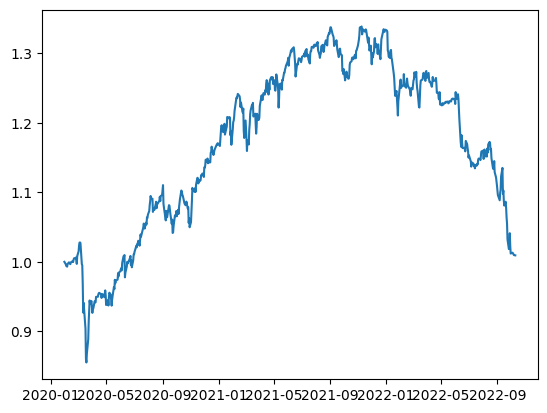

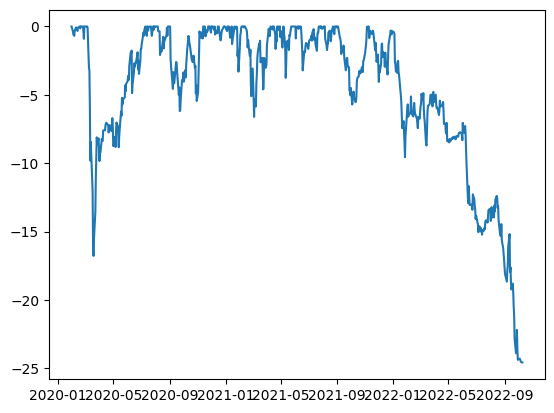

In [34]:
plt.figure()
plt.subplots()
plt.plot(cumRet)
plt.subplots()
plt.plot(-dd)